# <center> **PROJECT-6. Сегментирование клиентов онлайн-магазина подарков**

![Alt text](image.png)

## <center> **Постановка задачи**

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из *Google Analytics* или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/«спящие»/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

**Бизнес-задача:**

Произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:**

Построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

### <center> **Организационная информация**

Проект будет состоять из шести частей:

**`1.` Базовый анализ и знакомство с данными**;

**`2.` Предобработка и очистка данных**;

**`3.` Разведывательный анализ данных (EDA)**;

**`4.` RFM-сегментация клиентов. Часть I**;

**`5.` RFM-сегментация клиентов. Часть II**;

**`6.` RFM-сегментация клиентов. Часть III**.

## <center> **`1.` Базовый анализ и знакомство с данными**

**Импортируем необходимые библиотеки:**

In [1]:
# Для работы с данными
import pandas as pd
import numpy as np


# Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


# Для построения моделей
from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

**Прочитаем данные:**

In [2]:
# Загружаем DataFrame
csp_data = pd.read_csv(
    'Прочие файлы/customer_segmentation_project.csv',
    encoding = 'ISO-8859-1',
    
    dtype = {
        'CustomerID': str,
        'InvoiceID': str
    }
    
    )

# Создаём копию
csp_df = csp_data.copy()

In [3]:
# Выведем размерность данных
print(f'Размерность данных: {csp_df.shape}')

# Выведем первые пять строк
csp_df.head()

Размерность данных: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### <center> **Иформация о датасете**

* `InvoiceNo` — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква *"C"* в начале кода указывает на отмену транзакции);

* `StockCode` — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);

* `Description` — название товара;

* `Quantity` — количество каждого товара за транзакцию;

* `InvoiceDate` — дата и время выставления счёта/проведения транзакции;

* `UnitPrice` — цена за единицу товара в фунтах стерлингов;

* `CustomerID` — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);

* `Country` — название страны, в которой проживает клиент.

#### $1.1$

Выведем типизацию признаков:

In [4]:
csp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


#### $1.2$

Преобразуем столбец `InvoiceDate` в формат `datetime`.

Посмотрим, за какой промежуток времени представлены данные:

In [5]:
# Преобразовываем признак 
csp_df.InvoiceDate = pd.to_datetime(csp_df.InvoiceDate)

# Выводим самую раннюю и последнюю дату
print(f'Данные предоставлены за промежуток между {csp_df.InvoiceDate.min()} и {csp_df.InvoiceDate.max()} числом.')

Данные предоставлены за промежуток между 2010-12-01 08:26:00 и 2011-12-09 12:50:00 числом.


#### $1.3$

1. Выведем максимальное количество товаров в заказе (`Quantity`);
2. Выведем минимальное количество товаров в заказе (`Quantity`);
3. Выведем стоимость самого дешёвого товара.

In [6]:
# Создадим таблицу с положительными значениями стоимости товара
positive_price = csp_df[csp_df.UnitPrice > 0]

# Выводим значения
print(f'Макисмальное количество товаров в заказе: {csp_df.Quantity.max()}')
print(f'Минимальное количество товаров в заказе: {csp_df.Quantity.min()}')
print(f'Стоимость самого дешёвого товара: {round(positive_price.UnitPrice.min())}')

Макисмальное количество товаров в заказе: 80995
Минимальное количество товаров в заказе: -80995
Стоимость самого дешёвого товара: 0


Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

#### $1.4$

1. Выведем количество уникальных клиентов, которые покупали товары за период выгрузки датасета;
2. Выведем количество уникальных стран;
3. Выведем идентификатор самого популярного товара (`StockCode`).

In [7]:
# Создадим таблицу, в которой исключим специальный код 'Unspecified' из признака Country
data = csp_df[csp_df.Country != 'Unspecified']

# Выводим значения
print(f'Количество уникальных клиентов: {csp_df.CustomerID.nunique()}')
print(f'Количество уникальных стран: {data.Country.nunique()}')
print(f'Идентификатор самого популярного товара: {csp_df.StockCode.value_counts().head(1)}')

Количество уникальных клиентов: 4372
Количество уникальных стран: 37
Идентификатор самого популярного товара: 85123A    2313
Name: StockCode, dtype: int64


## <center> **`2.` Предобработка и очистка данных**

#### $2.1$

Проверим данные на наличие пропусков:

Суммарное количество пропусков в данных: 136534 

Информация по количествам пропусков: 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64 

CustomerID     24.926694
Description     0.268311
dtype: float64


<AxesSubplot:>

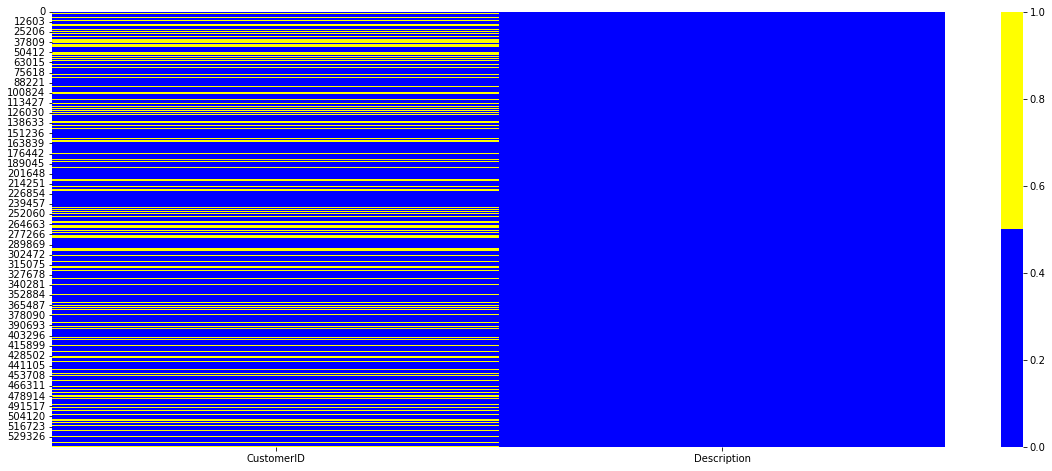

In [8]:
# Выводим суммарное количество пропусков
print('Суммарное количество пропусков в данных: {} \n'.format(csp_df.isnull().sum().sum()))

# Выводим признаки с сумрным количеством пропусков
print('Информация по количествам пропусков: \n\n{} \n'.format(csp_df.isnull().sum()))



# Построим тепловую карту пропусков
# Создаём функцию отображения пропущенных значений на тепловой карте
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax


# Применяем полученную функцию к нашему датасету
missing_values_heatmap(csp_df)

Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалим строки, содержащие пропуски в этих столбцах. 

In [9]:
# Удаляем строки с пропусками
csp_df = csp_df.dropna(subset = ['CustomerID'])
csp_df = csp_df.dropna(subset = ['Description'])

# Выводим размерность таблицы
print('Размерность таблицы после удаления пропусков: {}'.format(csp_df.shape))

Размерность таблицы после удаления пропусков: (406829, 8)


#### $2.2$

Проверим наличие дубликатов:

In [10]:
# Создаём список признаков
dupl_columns = list(csp_df.columns)

# Создаём маску дубликатов с помощью метода duplicated() и произведём фильтрацию
mask = csp_df.duplicated(subset = dupl_columns)
csp_duplicates = csp_df[mask]
print(f'Число найденных дубликатов: {csp_duplicates.shape[0]}')

Число найденных дубликатов: 5225


Удалим найденные дубликаты:

In [11]:
csp_df = csp_df.drop_duplicates(subset = dupl_columns)
print(f'Результирующее число записей: {csp_df.shape[0]}')

Результирующее число записей: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберёмся, откуда они взялись. Выведем первые пять строк таблицы, в которой столбец `Quantity` меньше 0.

In [12]:
# Создадим таблицу с отрицательными значениями количества товара
negative_quantity = csp_df[csp_df['Quantity'] < 0]

# Выводим количество данных товаров, а также первые 5 строк полученной таблицы
print('Количество записей с отрицательным числом: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество записей с отрицательным числом: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

* Номер заказа (`InvoiceNo`) и код товара (`StockCode`) могут содержать не только числа, но и символы.

* Как было сказано в описании датасета, символ *"C"* перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа *"C"* и c положительным количеством товара.

* Код товара может содержать различные специальные символы: например, символ *"D"*, судя по описанию товара (столбец `Description`), означает наличие скидки.

* Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

#### $2.3$

Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [13]:
# Создаём список, в который будем заносить номера заказа без признака возврата
Transaction_list = []


# Пройдёмся циклом for по всем номерам,
# номера, не содержащие символ 'C', будем заносить в список
for transaction in negative_quantity.InvoiceNo:
    if transaction[0] != 'C':
        Transaction_list.append(transaction)
   
        
# Выводим количество искомых транзакций
print('Количество транзакций, не содержащих в номере заказа признак возврата: {}'.format(len(Transaction_list)))

Количество транзакций, не содержащих в номере заказа признак возврата: 0


Все транзакции с отрицательным количеством товара являются возвратами.

Подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/*basket*) для каждой уникальной пары «клиент-заказ»:

In [14]:
# Группируем признаки идентификатора клиента и номера заказа по дате
temp = csp_df.groupby(
    by = ['CustomerID', 'InvoiceNo'],
    as_index = False
)['InvoiceDate'].count()


# Создаём признак количества товаров
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


#### $2.4$

Добавим во вспомогательную таблицу `nb_products_per_basket` признак отмены заказа (`order_canceled`): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [15]:
# Создаём lambda-функцию для определения отменённой транзакции
order_canceled = lambda x: 1 if x[0] == 'C' else 0

# Создаём признак 'order_canceled'
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(order_canceled)

# Считаем процент отменённых заказов
order_canceled_persent = nb_products_per_basket['order_canceled'].sum() / nb_products_per_basket.shape[0] * 100

# Выводим процент отменённых заказов
print('Доля отменённых заказов: {} %'.format(round(order_canceled_persent)))

Доля отменённых заказов: 16 %


Поближе взглянем на отменённые заказы:

In [16]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдём в таблице со всеми транзакциями записи, принадлежащие клиенту с идентификатором 12346:

In [17]:
csp_df[csp_df['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


#### $2.5$

**Выдвигаем гипотезу:** для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

Посмотрим на данные клиента с идентификатором 14527:

In [18]:
csp_df[csp_df['CustomerID'] == '14527'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Если обратить внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров не наблюдается.

Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги.

#### $2.6$

**Выдвигаем новую гипотезу:** для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Приведём транзакции, относящиеся к клиенту с идентификатором 15311 и товаром с кодом 35004C:

In [19]:
csp_df[(csp_df['CustomerID'] == '15311') & (csp_df['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


На **первой строке** мы видим заказ с отменой (номер заказа начинается с символа *"C"*). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.

По **двум следующим строкам** видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара).

Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками, мы не можем найти аналогов для некоторых отменённых заказов.

Создадим в данных о транзакциях признак `QuantityCanceled`, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.

Для этого создадим функцию `get_quantity_canceled()`. Она принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец `QuantityCanceled`.

In [20]:
def get_quantity_canceled(data):
    
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    
    
    
    for index, col in negative_quantity.iterrows():
        
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity'] 
                  
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
            
            
    return quantity_canceled



# Применяем полученную функцию ко всему датафрейму
csp_df['QuantityCanceled'] = get_quantity_canceled(csp_df)

#### $2.7$

Подсчитаем суммарное количество возвращённых товаров.

In [21]:
print(f'Суммарное количество возвращённых товаров: {round(csp_df.QuantityCanceled.sum())}')

Суммарное количество возвращённых товаров: 245266


#### $2.8$

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся.

Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара. 

In [22]:
# Производим фильтрацию строк по условию
csp_df = csp_df[csp_df.Quantity >= 0]
print(f'Количество записей таблицы: {csp_df.shape[0]}')

Количество записей таблицы: 392732


#### $2.9$

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак `StockCode` обозначен как *"D"*. Проверим, бывают ли другие специальные коды ↓

С помощью регулярных выражений найдём такие коды товаров (`StockCode`), которые начинаются с латинских букв, но при этом коды могут содержать цифры.

In [23]:
# Создаём признак 'SpecialCode'
csp_df['SpecialCode'] = csp_df['StockCode'].str.contains('^[a-zA-Z]+', regex = True)

# Создаём список уникальных значений
unique_symbols = []

# Проходимся циклом по строкам и заносим в список выявленные коды товаров
for index, row in csp_df.iterrows():
    if (row['SpecialCode'] is True) & (row['StockCode'] not in unique_symbols):
        unique_symbols.append(row['StockCode'])
        
        
# Выводим список
print('Данные содержат следующие виды транзакций: {}'.format(unique_symbols))

Данные содержат следующие виды транзакций: ['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']


Так как специальные операции не характеризуют наших клиентов, такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [24]:
# Удалим строки, которые содержат специальные операции
csp_df = csp_df[csp_df.StockCode.isin(unique_symbols) == False]
print(f'Количество записей таблицы: {csp_df.shape[0]}')

Количество записей таблицы: 391183


#### $2.10$

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов.

**1.** Выведем количество транзакций, в которых цена за единицу товара равна 0:

In [25]:
price_zero = csp_df[csp_df.UnitPrice == 0]
print('Количество транзакций: {}'.format(price_zero.shape[0]))

Количество транзакций: 33


**2.** Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалим такие транзакции из таблицы.

In [26]:
csp_df = csp_df[csp_df.UnitPrice != 0]
print(f'Количество записей таблицы: {csp_df.shape[0]}')

Количество записей таблицы: 391150


## <center> **`3.` Разведывательный анализ данных (EDA)**

Теперь займёмся разведывательным анализом и исследуем транзакции.

В данном разделе решим следующие задачи:

* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

#### $3.1$

Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран. 

Распределение количества клиентов по странам: 

                 Country  CustomerID
35        United Kingdom      348872
14               Germany        8643
13                France        8019
10                  EIRE        7126
30                 Spain        2417
23           Netherlands        2322
3                Belgium        1935
32           Switzerland        1810
26              Portugal        1416
0              Australia        1180
24                Norway        1048
6        Channel Islands         743
18                 Italy         741
12               Finland         647
7                 Cyprus         601
31                Sweden         427
1                Austria         384
9                Denmark         367
25                Poland         325
19                 Japan         321
17                Israel         245
36           Unspecified         241
29             Singapore         215
16               Iceland         182
33                   USA   

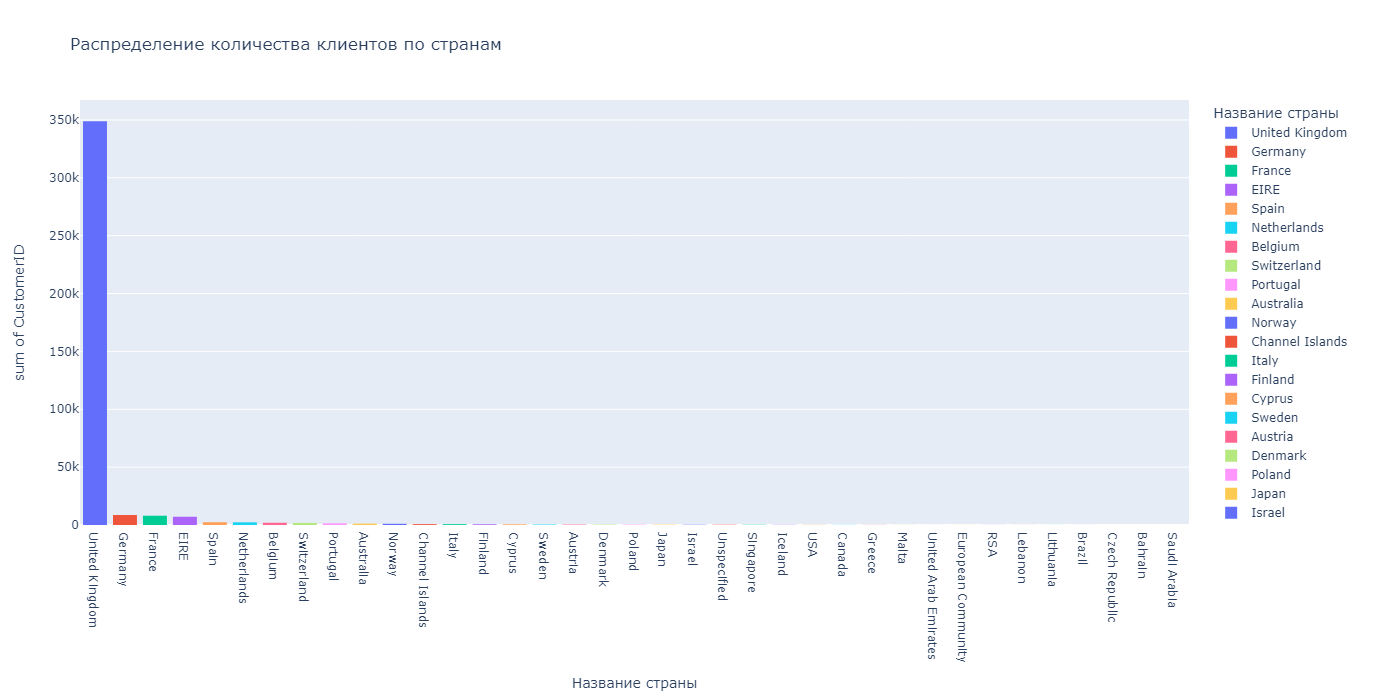

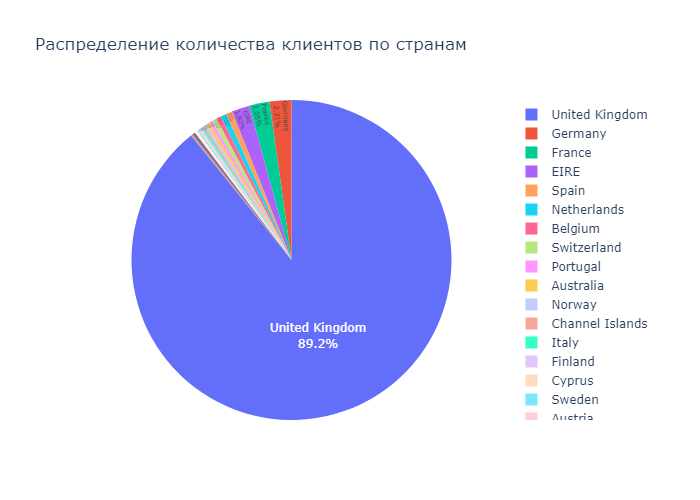

In [27]:
# Создаём DataFrame, в котором отразим количество уникальных клиентов по странам
customer_group = csp_df.groupby(
    by = 'Country',
    as_index = False
)[['CustomerID']].count().sort_values(by = 'CustomerID', ascending = False)

# Выводим таблицу
print('Распределение количества клиентов по странам: \n\n{}'.format(customer_group))



# Строим график
fig = px.histogram(
    data_frame = customer_group,
    x = 'Country',
    y = 'CustomerID',
    color = 'Country',
    height = 700,
    width = 1400,
    
    labels = {
        'Country': 'Название страны',
        'sum of CustomerID': 'Количество клиентов'
    },
    
    title = 'Распределение количества клиентов по странам'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = customer_group,
    values = 'CustomerID',
    names = 'Country',
    labels = 'Country',
    title = 'Распределение количества клиентов по странам'
)

# Выводим график
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.show('png')

#### $3.2$

Построим визуализацию и выделим топ-10 стран по количеству поступающих заказов:

Распределение количества заказов по странам: 

           Country  Quantity
35  United Kingdom    348872
14         Germany      8643
13          France      8019
10            EIRE      7126
30           Spain      2417
23     Netherlands      2322
3          Belgium      1935
32     Switzerland      1810
26        Portugal      1416
0        Australia      1180


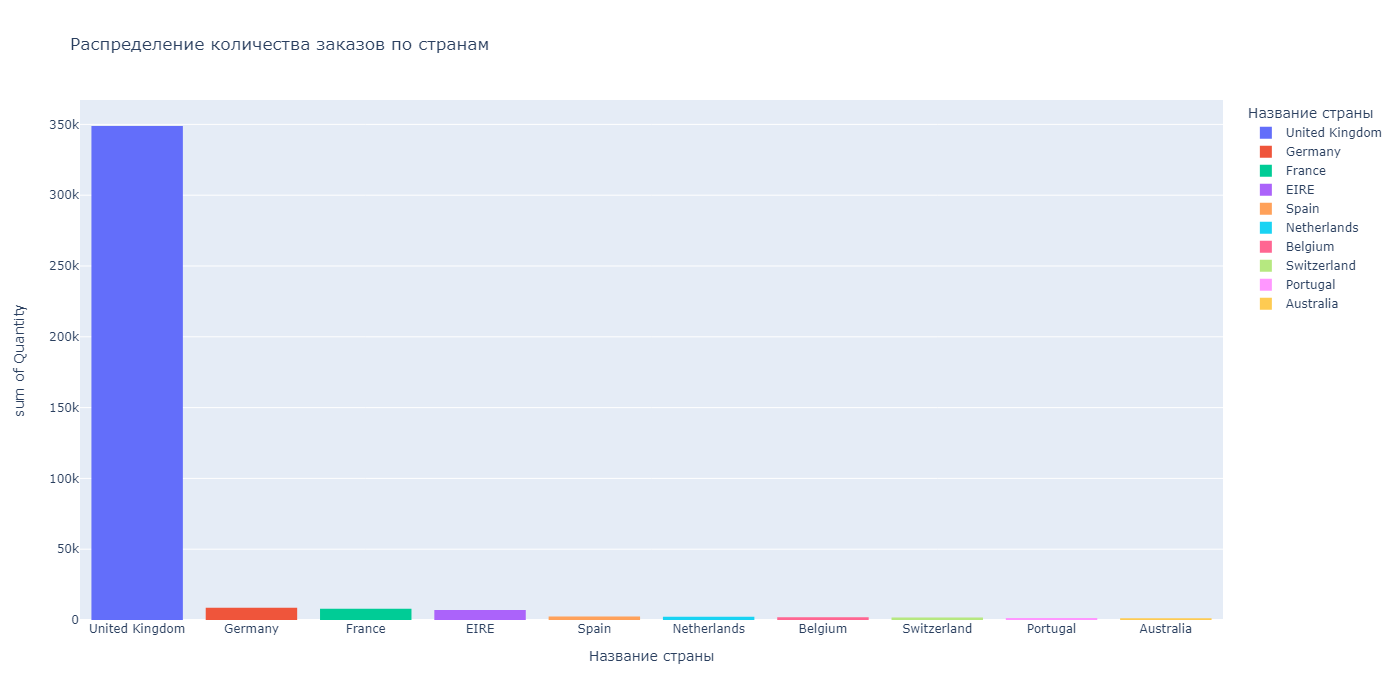

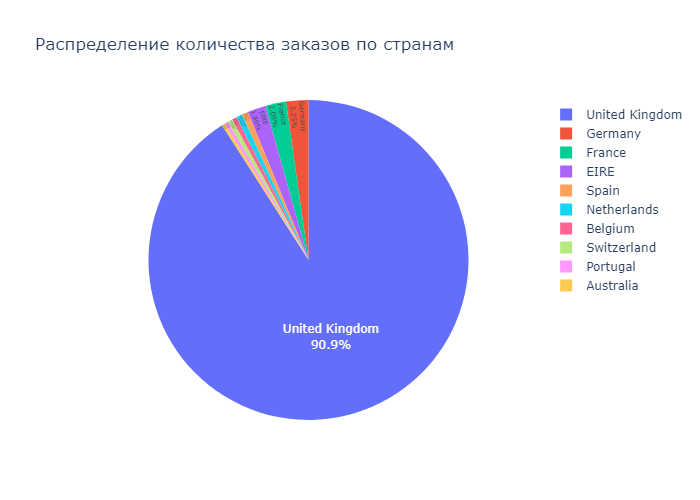

In [28]:
# Создаём DataFrame, в котором отразим количество заказов по странам
quantity_group = csp_df.groupby(
    by = 'Country',
    as_index = False
)[['Quantity']].count().sort_values(by = 'Quantity', ascending = False).nlargest(10, columns = ['Quantity'])

# Выводим таблицу
print('Распределение количества заказов по странам: \n\n{}'.format(quantity_group))



# Строим график
fig = px.histogram(
    data_frame = quantity_group,
    x = 'Country',
    y = 'Quantity',
    color = 'Country',
    height = 700,
    width = 1400,
    
    labels = {
        'Country': 'Название страны',
        'sum of Quantity': 'Количество заказов'
    },
    
    title = 'Распределение количества заказов по странам'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = quantity_group,
    values = 'Quantity',
    names = 'Country',
    labels = 'Country',
    title = 'Распределение количества заказов по странам'
)

# Выводим график
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.show('png')

#### $3.3$

Добавим в датасет признак, который будет характерезовать общую цену заказа, назовём его `TotalPrice`.

In [29]:
# Создаём признак
csp_df['TotalPrice'] = 0


# Создаём функцию, с помощь которой произведём следующие вычисления:
# общая цена = цена за еденицу товара X (количество товаров в заказе - количество возвращённых товаров)
def  total_price_calculation(row):
    row.TotalPrice = row.UnitPrice * (row.Quantity - row.QuantityCanceled)
    return row

# Применяем полученную функцию ко всему датафрейму
csp_df = csp_df.apply(lambda row: total_price_calculation(row), axis = 1)

In [30]:
# Выведем среднюю общую стоимость заказов
print(f'Средняя общая стоимость заказов: {round(csp_df.TotalPrice.mean())}')

Средняя общая стоимость заказов: 21


#### $3.4$

Построим визуализацию и выделим топ-10 стран, клиенты из которых приносят компании больше всего выручки:

Распределение размера выручки по странам: 

           Country  TotalPrice
35  United Kingdom  6797691.44
23     Netherlands   283443.54
10            EIRE   247074.57
14         Germany   201520.71
13          France   181529.63
0        Australia   136950.25
32     Switzerland    51863.75
30           Spain    51764.90
3          Belgium    36673.04
31          Sweden    36362.91


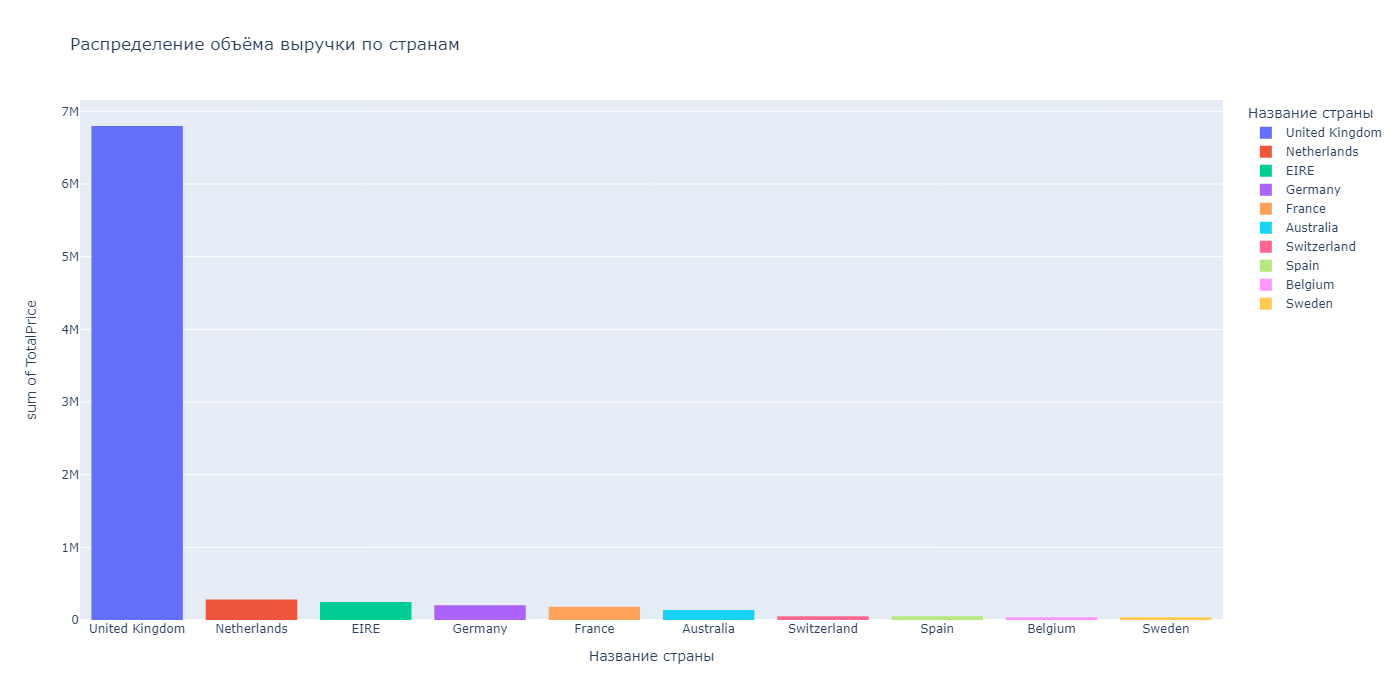

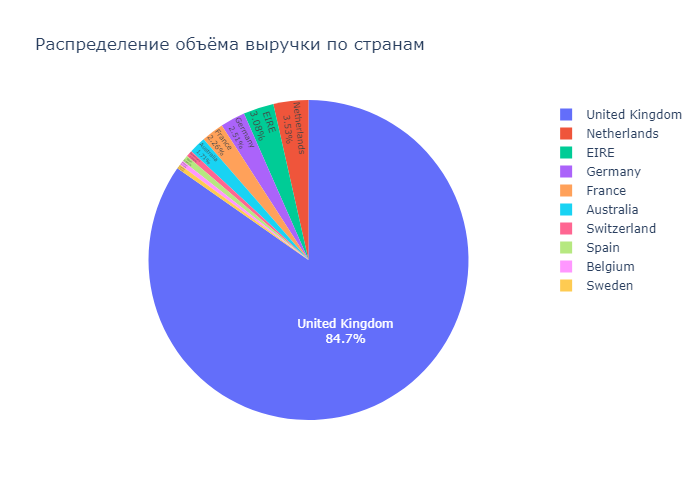

In [31]:
# Создаём DataFrame, в котором отразим размер выручки по странам
TotalPrice_group = csp_df.groupby(
    by = 'Country',
    as_index = False
)[['TotalPrice']].sum().sort_values(by = 'TotalPrice', ascending = False).nlargest(10, columns = ['TotalPrice'])

# Выводим таблицу
print('Распределение размера выручки по странам: \n\n{}'.format(TotalPrice_group))



# Строим график
fig = px.histogram(
    data_frame = TotalPrice_group,
    x = 'Country',
    y = 'TotalPrice',
    color = 'Country',
    height = 700,
    width = 1400,
    
    labels = {
        'Country': 'Название страны',
        'sum of TotalPrice': 'Размер выручки'
    },
    
    title = 'Распределение объёма выручки по странам'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = TotalPrice_group,
    values = 'TotalPrice',
    names = 'Country',
    labels = 'Country',
    title = 'Распределение объёма выручки по странам'
)

# Выводим график
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.show('png')

#### $3.5$

Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

In [32]:
# Создаём признак месяца совершения покупки
csp_df['InvoiceMonth'] = 0

def get_month(row):
    row.InvoiceMonth = row.InvoiceDate.strftime('%m')
    return row



# Создаём признак дня совершения покупки
csp_df['InvoiceDay'] = 0

def get_day(row):
    row.InvoiceDay = row.InvoiceDate.strftime('%d')
    return row



# Создаём признак часа совершения покупки
csp_df['InvoiceHour'] = 0

def get_hour(row):
    row.InvoiceHour = row.InvoiceDate.strftime('%H')
    return row



# Применяем полученные функции ко всему датафрейму
csp_df = csp_df.apply(lambda row: get_month(row), axis = 1)
csp_df = csp_df.apply(lambda row: get_day(row), axis = 1)
csp_df = csp_df.apply(lambda row: get_hour(row), axis = 1)



# Конвертируем полученные признаки в тип int
csp_df['InvoiceMonth'] = csp_df['InvoiceMonth'].astype(int)
csp_df['InvoiceDay'] = csp_df['InvoiceDay'].astype(int)
csp_df['InvoiceHour'] = csp_df['InvoiceHour'].astype(int)

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

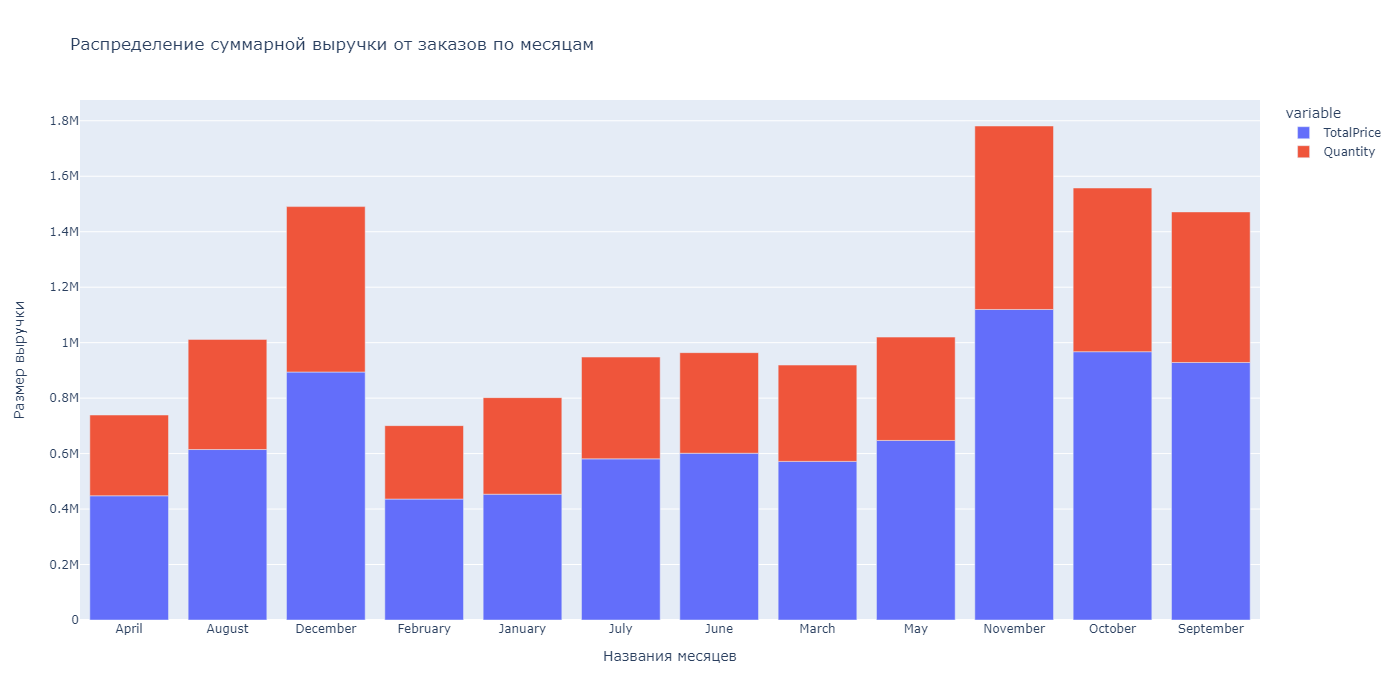

In [33]:
# Создаём признак названий месяцев
csp_df['month_name'] = csp_df['InvoiceDate'].dt.month_name()



# Создаём DataFrame, в котором отразим размер выручки по месяцам
bar_data = csp_df.groupby(
    by = 'month_name',
    as_index = False
).sum()



# Строим столбчатую диаграмму
fig = px.bar(
    data_frame = bar_data,
    x = 'month_name',
    y = ['TotalPrice', 'Quantity'], 
    height = 700,
    width = 1400,
    
    labels = {
        'month_name': 'Названия месяцев',
        'value': 'Размер выручки'
    },
    
    title = 'Распределение суммарной выручки от заказов по месяцам'
)

# Выводим график
fig.show('png')

**Вывод:**

Самый прибыльный месяц для компании - это ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

In [34]:
# Удалим признак 'month_name', так как он больше не нужен
csp_df = csp_df.drop('month_name', axis = 1)

#### $3.6$

Построим визуализацию количества заказов для каждого дня недели.

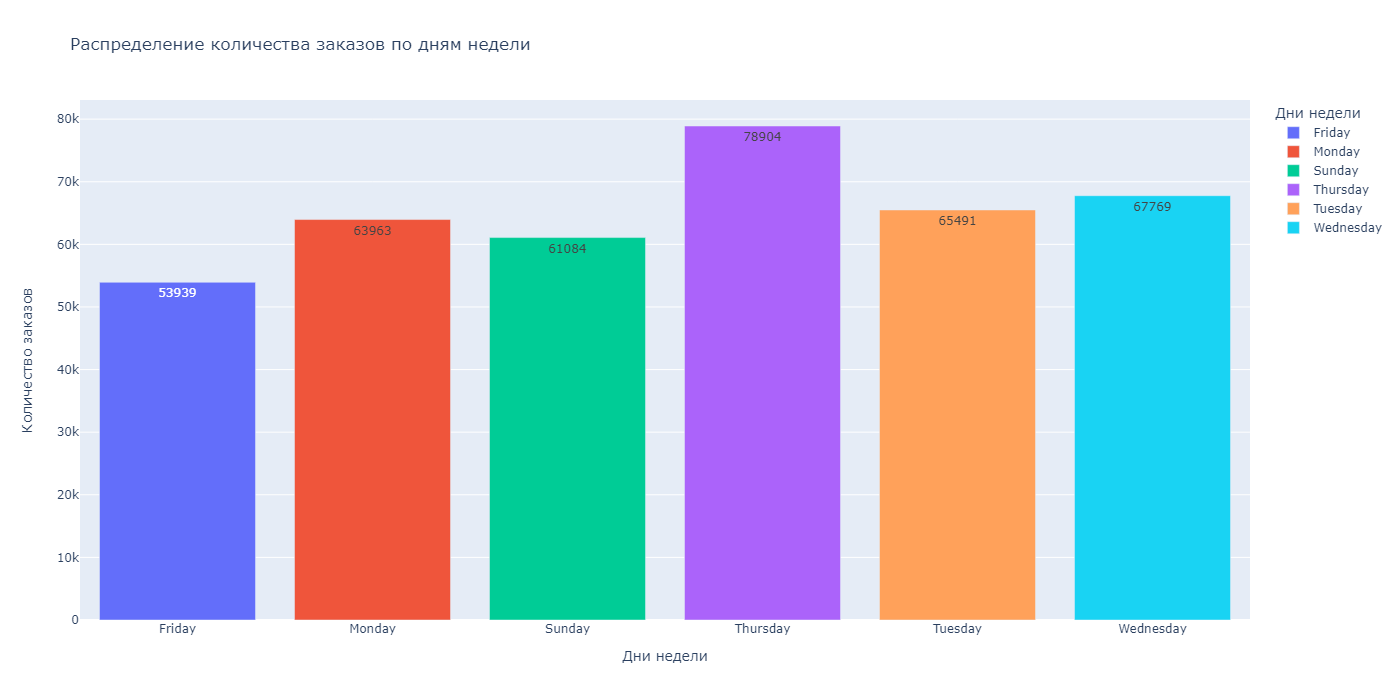

In [71]:
# Создаём признак дней недели
csp_df['day_of_week'] = csp_df['InvoiceDate'].dt.day_name()



# Создаём DataFrame, в котором отразим количество заказов по дням недели
bar_data = csp_df.groupby(
    by = 'day_of_week',
    as_index = False
)[['Quantity']].count()



# Строим гистограмму
fig = px.bar(
    data_frame = bar_data,
    x = 'day_of_week',
    y = 'Quantity',
    color = 'day_of_week',
    height = 700,
    width = 1400,
    text = 'Quantity',
    
    labels = {
        'day_of_week': 'Дни недели',
        'Quantity': 'Количество заказов'
    },
    
    title = 'Распределение количества заказов по дням недели'
)

# Выводим график
fig.show('png')

**Вывод:**

Согласно данным, нет ни одной транзакции, совершённой в субботу (Saturday). Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

In [72]:
# Удалим признак 'day_of_week', так как он больше не нужен
csp_df = csp_df.drop('day_of_week', axis = 1)

#### $3.7$

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

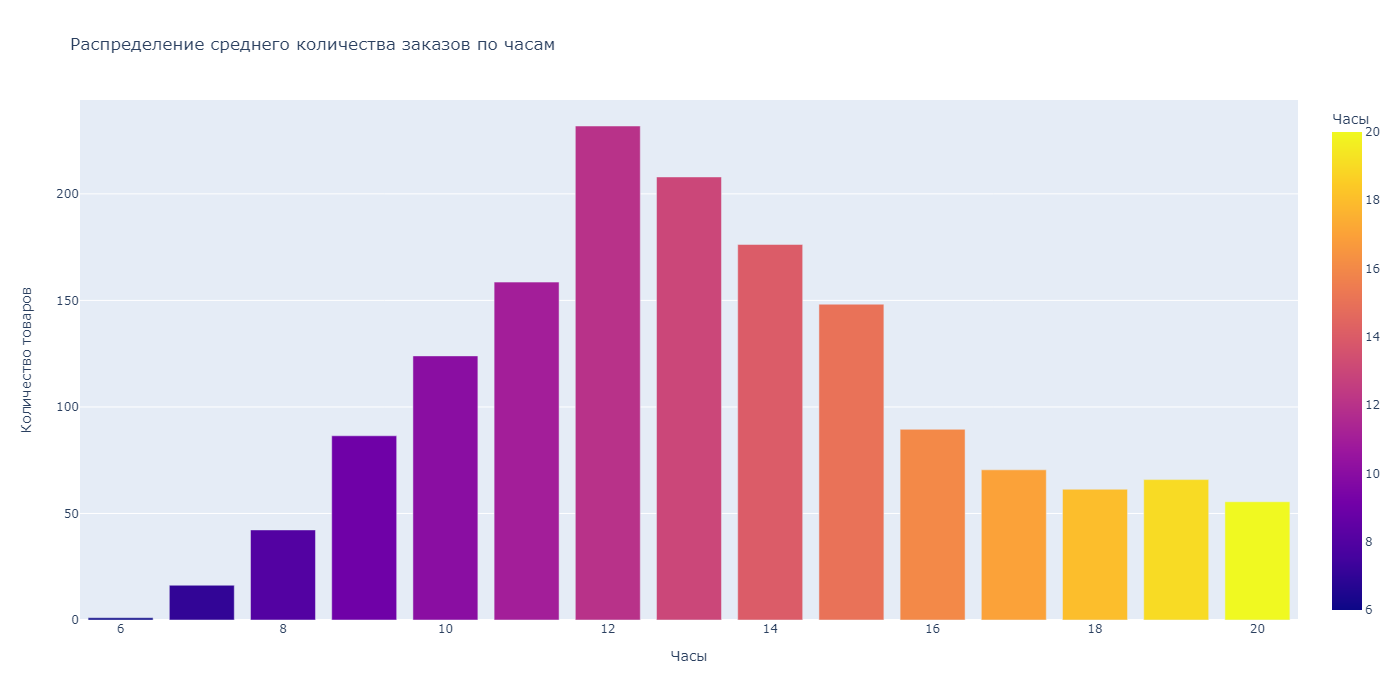

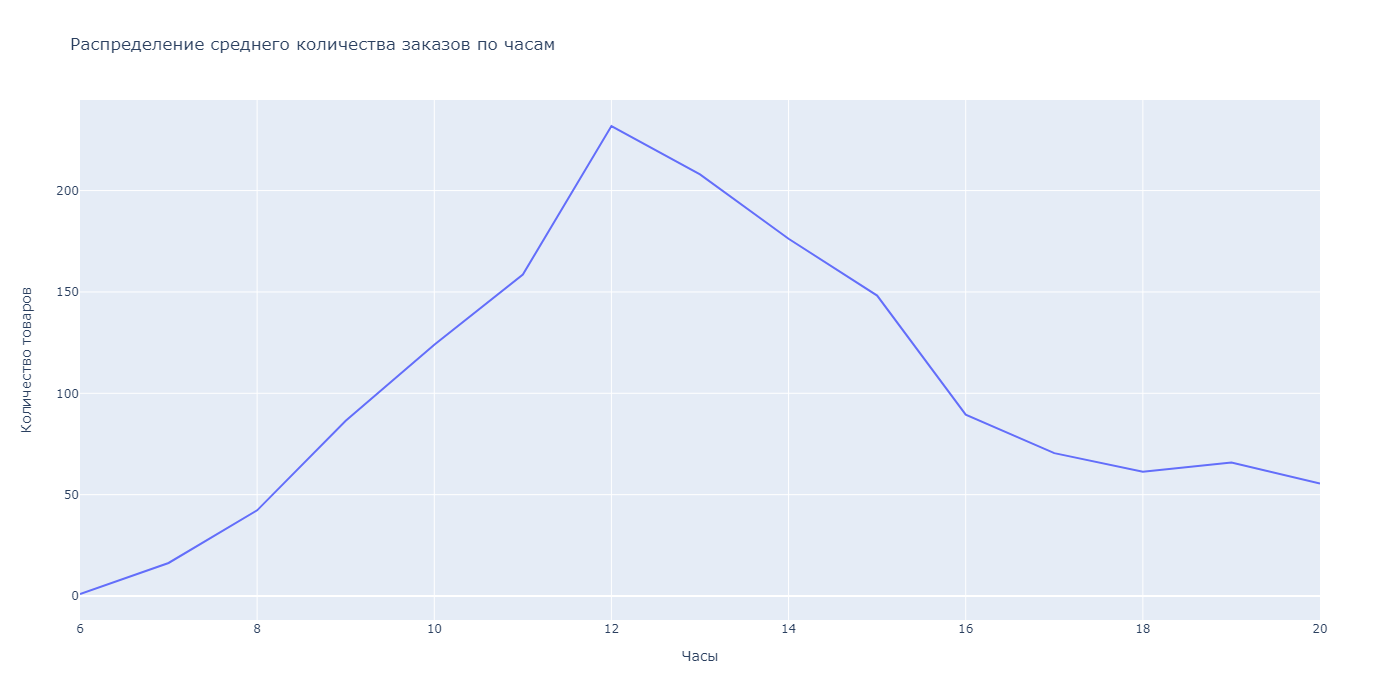

In [66]:
# Выделяем дату из признака времени совершения транзакции 
csp_df['Date'] = csp_df.InvoiceDate.dt.date



# Производим группировку данных по датам и часам совершения транзакций от количества заказов
DateHour_grouped = csp_df.groupby(
    by = ['Date', 'InvoiceHour'],
    as_index = False
    )[['Quantity']].count()



# Производим группировку по часам и среднему количеству товаров
HourQuantity_grouped = DateHour_grouped.groupby(
    by = 'InvoiceHour',
    as_index = False
)[['Quantity']].mean()



# Строим столбчатую диаграмму
fig = px.bar(
    data_frame = HourQuantity_grouped,
    x = 'InvoiceHour',
    y = 'Quantity',
    color = 'InvoiceHour',
    height = 700,
    width = 1400,
    
    labels = {
        'InvoiceHour': 'Часы',
        'Quantity': 'Количество товаров'
    },
    
    title = 'Распределение среднего количества заказов по часам'
)

# Выводим график
fig.show('png')



# Строим линейную диаграмму
fig = px.line(
    data_frame = HourQuantity_grouped,
    x = 'InvoiceHour',
    y = 'Quantity',
    height = 700,
    width = 1400,
    
    labels = {
        'InvoiceHour': 'Часы',
        'Quantity': 'Количество товаров'
    },
    
    title = 'Распределение среднего количества заказов по часам'
)

# Выводим график
fig.show('png')

**Выводы:**

* Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов.
* С 21 часа до 6 утра (не включительно) заказы не поступают.

## <center> **`4.` RFM-сегментация клиентов. Часть I**

В данной части проекта необходимо сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого воспользуемся методом для анализа потребительской ценности под названием **RFM**.

Метод заключается в группировке клиентов на основе следующих параметров:

* **Recency** (Давность) — давность последней покупки клиента;
* **Frequency** (Частота) — общее количество покупок клиента;
* **Monetary Value** (Денежная ценность) — сколько денег потратил клиент.

Рассчитаем *RFM*-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построим подобные сегменты клиентов, привязанные к нашим данным.

In [31]:
# В качестве точки отсчёта возьмём 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').
first_date = pd.to_datetime('2011-12-10')

# Производим рассчёт в соответствии с требуемыми параметрами
custom_aggregation = {
    'InvoiceDate': lambda x: (first_date - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum()
}

# Создаём RFM таблицу
RFM_data = csp_df.groupby('CustomerID').agg(custom_aggregation)

# Переименовываем столбцы
RFM_data = RFM_data.rename(
    columns = {
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'TotalPrice': 'Monetary',
        'TotalQuantity': 'MeanQuantity'
    }
)

In [32]:
# Выведем первые пять строк
RFM_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


#### $4.1$

Проведём небольшое исследование:

In [33]:
# Выведем количество клиентов, совершивших покупку более 200 дней назад
data = RFM_data[RFM_data['Recency'] > 200]
print('Количество клиентов, совершивших покупку более 200 дней назад: {}'.format(data.Frequency.count()))

# Выведем количество заказов, которое в среднем делает клиент
print('Среднее количество заказов: {}'.format(round(RFM_data.Frequency.mean())))

# Выведем общую сумму денег, которую потратил клиент с идентификатором 12360
print('Сумма расходов клиента 12360: {} £'.format(round(RFM_data.loc[['12360']].Monetary[0])))

Количество клиентов, совершивших покупку более 200 дней назад: 743
Среднее количество заказов: 4
Сумма расходов клиента 12360: 2302 £


Теперь выведем коробчатые диаграммы для каждого из признаков:

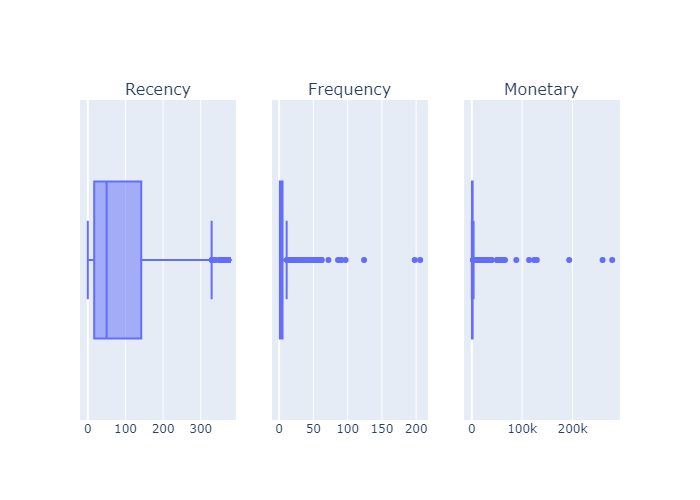

In [34]:
boxes = [px.box(RFM_data, x = column) for column in RFM_data.columns]

# Строим диаграммы
fig = make_subplots(
    rows = 1, cols = 3,
    subplot_titles = (
        'Recency', 'Frequency', 'Monetary'
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row = 1, col = i + 1)
    
    
fig.update_layout(showlegend = True)
fig.show('png')

**Вывод:**

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов. Удалим данные тех клиентов, для которых значение параметра *Frequency* или параметра *Monetary* выше, чем у 95 % клиентов.

#### $4.2$

Удалим из *RFM*-таблицы потенциальные выбросы:

In [35]:
# Создаём функцию для выявления и удаления потенциальных выбросов
def outliers_iqr(data, feature1, feature2):
    
    x1 = data[feature1]
    x2 = data[feature2]
    quartile1 = x1.quantile(0.95)
    quartile2 = x2.quantile(0.95)
    cleaned_data = data[(x1 <= quartile1) & (x2 <= quartile2)]
    
    return cleaned_data


# Применяем полученную функцию к признакам 'Frequency' и 'Monetary'
RFM_cleaned_data = outliers_iqr(RFM_data, 'Frequency', 'Monetary')

In [36]:
# Выведем итоговое количество клиентов
print('Итоговое количество клиентов: {}'.format(RFM_cleaned_data.shape[0]))

Итоговое количество клиентов: 4044


После удаления выбросов заново построим коробчатые диаграммы:

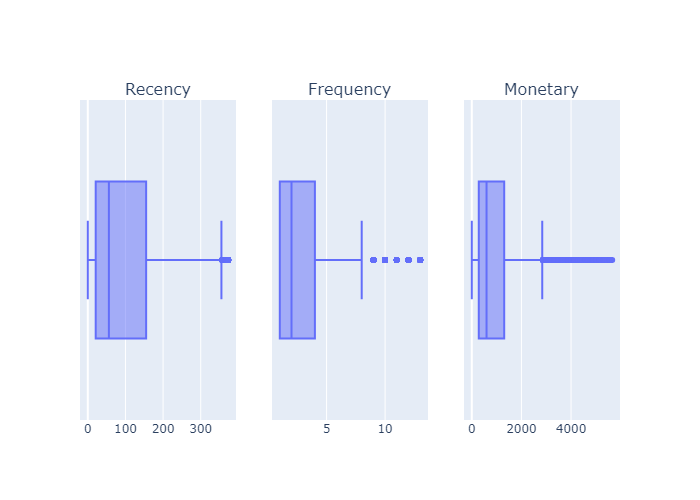

In [37]:
boxes = [px.box(RFM_cleaned_data, x = column) for column in RFM_cleaned_data.columns]

# Строим диаграммы
fig = make_subplots(
    rows = 1, cols = 3,
    subplot_titles = (
        'Recency', 'Frequency', 'Monetary'
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row = 1, col = i + 1)
    
    
    
fig.update_layout(showlegend = True)
fig.show('png')

Перед началом кластеризации необходимо оценить, как распределены наблюдения в пространстве признаков. Так как у нас всего три параметра, по которым мы хотим кластеризовать клиентов, визуализируем данные в виде трёхмерной диаграммы рассеяния.

Построим визуализацию нашего трёхмерного пространства признаков:

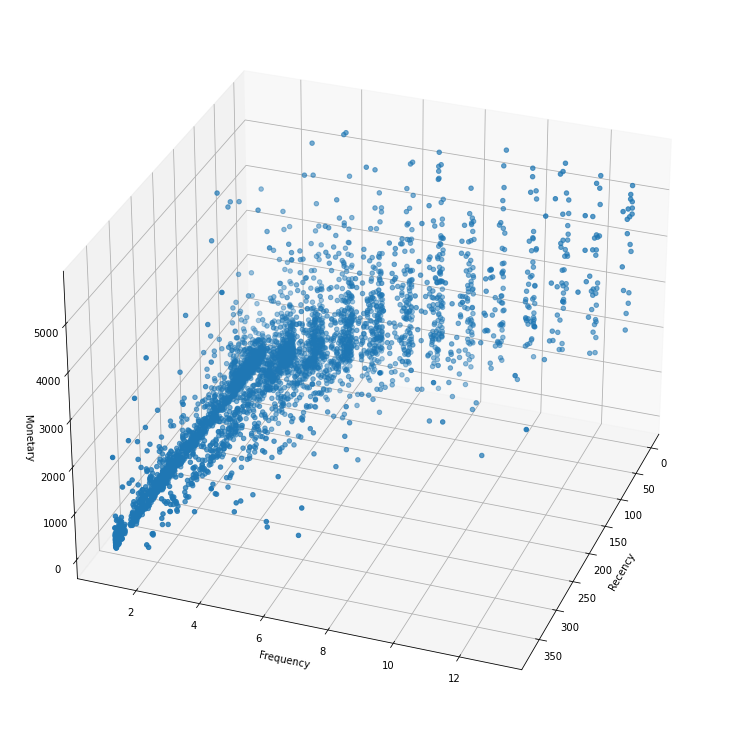

In [38]:
# Создадим трёхмерный объект
fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig)

# Добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# Визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    RFM_cleaned_data['Recency'].to_list(),
    RFM_cleaned_data['Frequency'].to_list(),
    RFM_cleaned_data['Monetary'].to_list()
)

# Добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

**Вывод:**

По данному графику сложно что-либо заключить. Видно, что есть клиенты с большими значениями параметров *Monetary* и *Frequency* — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Прибегнем к методам снижения размерности.

#### $4.3$

Воспользуемся методом главных компонент (*PCA*). Для его стабильной работы данные необходимо стандартизировать/нормализовать. Для удобства обернём эти шаги по предобработке данных в *pipeline*.

Создадим *pipeline*, в котором будут следующие шаги:

* стандартизация с помощью *StandardScaler* с параметрами по умолчанию;
* метод главных компонент с двумя компонентами.

Обучим *pipeline* на *RFM*-таблице, очищенной от выбросов, и применим к ней трансформацию.

In [39]:
# Инициализируем StandardScaler
STD_scaler = preprocessing.StandardScaler()

# Oпределяем метод главных компонент с двумя компонентами
pca = decomposition.PCA(n_components = 2)

# Задаём объект класса pipeline
pipeline_pca = pipeline.Pipeline([
    ('scaler', STD_scaler),
    ('PCA', pca)
])


# Обучаем pipeline и применяем трансформацию к очищенной таблице
RFM_processed_pca_data = pipeline_pca.fit_transform(RFM_cleaned_data)

In [40]:
# Выводим долю дисперсии исходных данных, котораую объясняет первая главная компонента
print('Доля диспресии главной компоненты: {:.2f}'.format(pipeline_pca['PCA'].explained_variance_ratio_[0]))

Доля диспресии главной компоненты: 0.68


Визуализируем пространство главных компонент после декомпозиции:

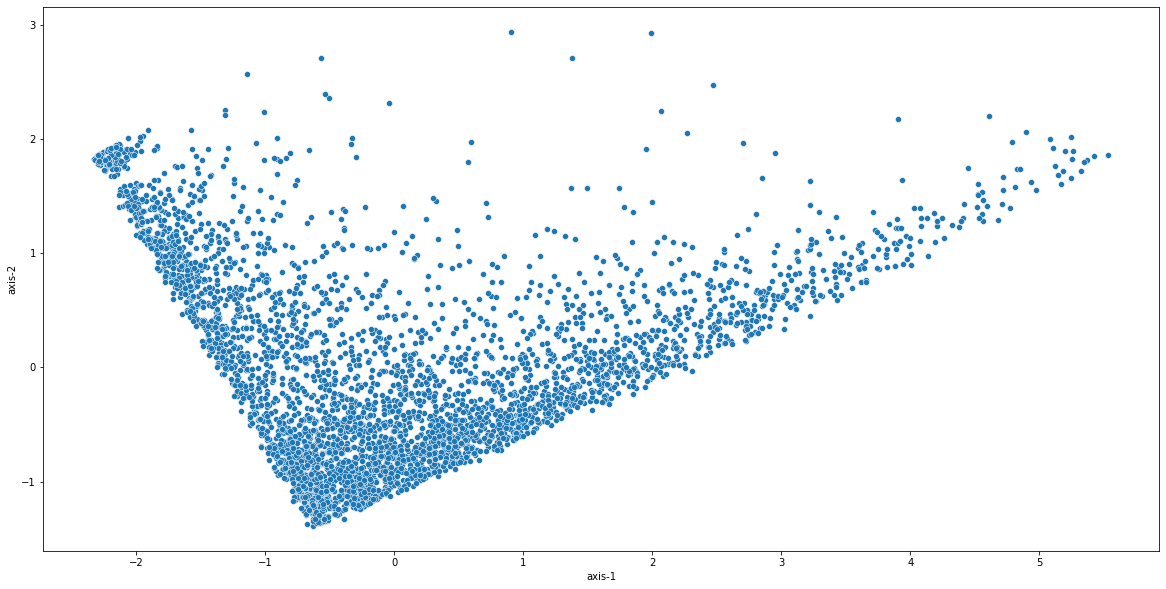

In [41]:
# Создаём DataFrame из полученной таблицы
RFM_processed_pca_data = pd.DataFrame(
    data = RFM_processed_pca_data,
    columns = ['axis-1', 'axis-2'],
    index = RFM_cleaned_data.index
)

# Задаём параметры графика и строим его
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(
    data = RFM_processed_pca_data,
    x = 'axis-1',
    y = 'axis-2'
);

Попробуем разделить это пространство главных компонент на сегменты.

#### $4.4$

Воспользуемся методом *k-means*.

Подберём оптимальное количество кластеров для метода *k-means* с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. В качестве значения параметра `random_state` возьмём число 42. Остальные параметры оставим по умолчанию.

In [42]:
# Проходимся циклом по всем нужным нам значениям количества кластеров
for silhouette in range(2, 11):
    
    # Создаём объект класса KMeans
    KM_model = cluster.KMeans(
        n_clusters = silhouette,
        random_state = 42
    )
    
    # Oбучаем модель k-means с текущим количеством кластеров
    KM_model.fit(RFM_processed_pca_data)
    
    # Предсказываем метки
    KM_predict = KM_model.labels_
    
    # Выводим результат для коэффициента силуэта
    print('Результат коэффициента силуэта {}: {:.2f}'.format(silhouette, metrics.silhouette_score(RFM_processed_pca_data, KM_predict)))

Результат коэффициента силуэта 2: 0.50
Результат коэффициента силуэта 3: 0.52
Результат коэффициента силуэта 4: 0.50
Результат коэффициента силуэта 5: 0.45
Результат коэффициента силуэта 6: 0.45
Результат коэффициента силуэта 7: 0.42
Результат коэффициента силуэта 8: 0.42
Результат коэффициента силуэта 9: 0.41
Результат коэффициента силуэта 10: 0.40


#### $4.5$

Теперь возьмём *EM*-алгоритм.

Подберём оптимальное количество кластеров для *EM*-алгоритма (*GaussianMixture*) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. В качестве значения параметра `random_state` возьмём число 42. Остальные параметры оставим по умолчанию.

In [43]:
# Проходимся циклом по всем нужным нам значениям количества кластеров
for silhouette in range(2, 11):
    
    # Создаём объект класса GaussianMixture
    GM_model = mixture.GaussianMixture(
        n_components = silhouette,
        random_state = 42
    )
    
    # Обучаем модель и предсказываем метки
    GM_predict = GM_model.fit_predict(RFM_processed_pca_data)
    
    # Выводим результат для коэффициента силуэта
    print('Результат коэффициента силуэта {}: {:.2f}'.format(silhouette, metrics.silhouette_score(RFM_processed_pca_data, GM_predict)))

Результат коэффициента силуэта 2: 0.34
Результат коэффициента силуэта 3: 0.44
Результат коэффициента силуэта 4: 0.35
Результат коэффициента силуэта 5: 0.25
Результат коэффициента силуэта 6: 0.27
Результат коэффициента силуэта 7: 0.20
Результат коэффициента силуэта 8: 0.20
Результат коэффициента силуэта 9: 0.16
Результат коэффициента силуэта 10: 0.11


#### **Вывод:**

Наилучшие значения параметров показала модель *K-means*.

#### $4.6$

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.

In [44]:
# Создаём объект класса KMeans
KM_model = cluster.KMeans(
    n_clusters = 3,
    random_state = 42
)

# Обучаем модель
KM_model.fit(RFM_processed_pca_data)


# Выведем группы, а также количества входящих в них клиентов
RFM_processed_pca_data.loc[:, 'label'] = KM_model.labels_
print(f'Группы, а также количества входящих в них клиентов: \n\n{RFM_processed_pca_data.label.value_counts()}')

Группы, а также количества входящих в них клиентов: 

2    2269
0     999
1     776
Name: label, dtype: int64


Визуализируем результаты кластеризации:

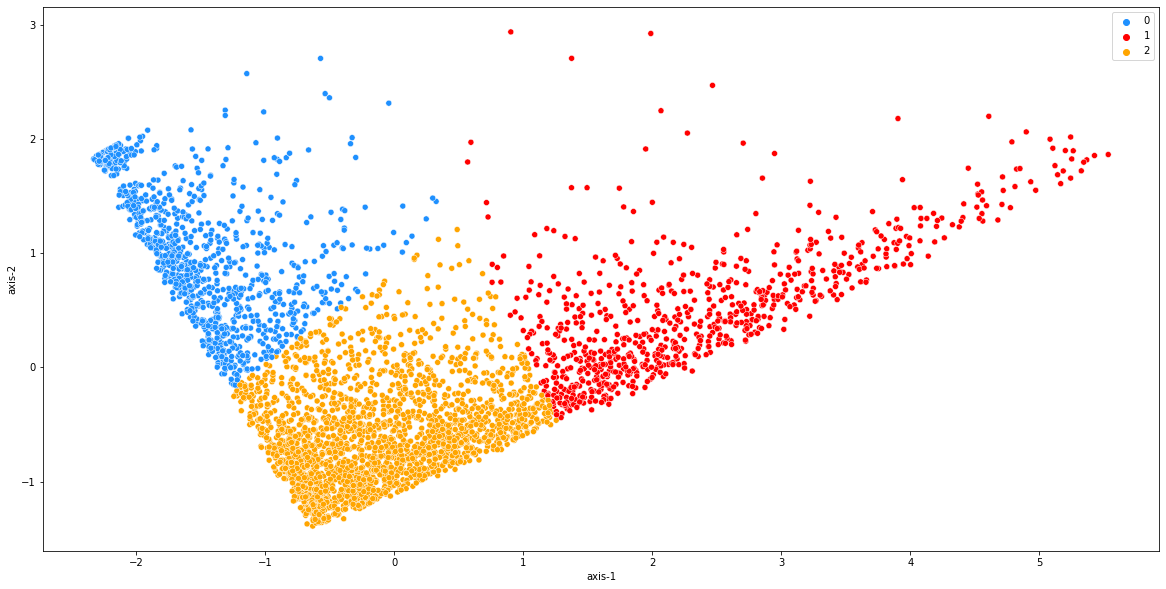

In [45]:
# Задаём параметры графика и строим его
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(
    data = RFM_processed_pca_data,
    x = 'axis-1',
    y = 'axis-2',
    palette = ['dodgerblue', 'red', 'orange'],
    hue = KM_model.labels_
);

Итак, у нас есть три сегмента клиентов. Составим профиль для этих сегментов.

#### $4.7$

Для составления профиля кластеров необходимо вернуться от декомпозированных данных к *RFM*-таблице, очищенной от выбросов. Сгруппируем *RFM*-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [46]:
# Создаём столбец содержащий кластеры
labels = pd.Series(
    data = KM_model.labels_.astype('str'),
    index = RFM_processed_pca_data.index
)


# Производим группировку
cluster_pca_grouped = RFM_cleaned_data.groupby(labels).mean().round(0)

Построим **полярную диаграмму**. Для этого реализуем функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы.

In [61]:
def plot_cluster_profile(data, n_clusters):
    
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    MM_scaler = preprocessing.MinMaxScaler()
    data = pd.DataFrame(MM_scaler.fit_transform(data), columns = data.columns)
    
    # Создаём список признаков
    features_list = data.columns
    
    # Создаём пустую фигуру
    fig = go.Figure()
    
    
    
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r = data.iloc[i].values,  # радиусы
            theta = features_list,    # название засечек
            fill = 'toself',          # заливка многоугольника цветом
            name = f'Cluster {i}'     # название — номер кластера
        ))
        
        
        
        # Обновляем параметры фигуры
        fig.update_layout(
            showlegend = True,  # отображение легенды
            autosize = False,   # устанавливаем свои размеры графика
            width = 800,        # ширина (в пикселях)
            height = 800        # высота (в пикселях)
        )
        
        
        
        # Отображаем фигуру
        fig.show('png')

#### $4.8$

Визуализируем профили кластеров в виде полярной диаграммы на основе средних *RFM*-характеристик, вычисленных для каждого кластера.

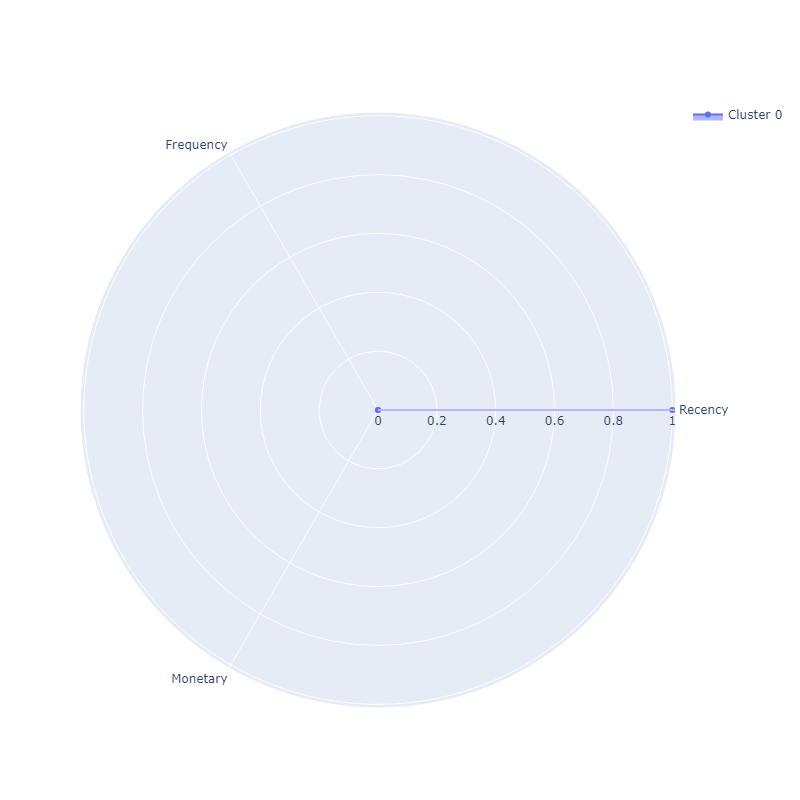

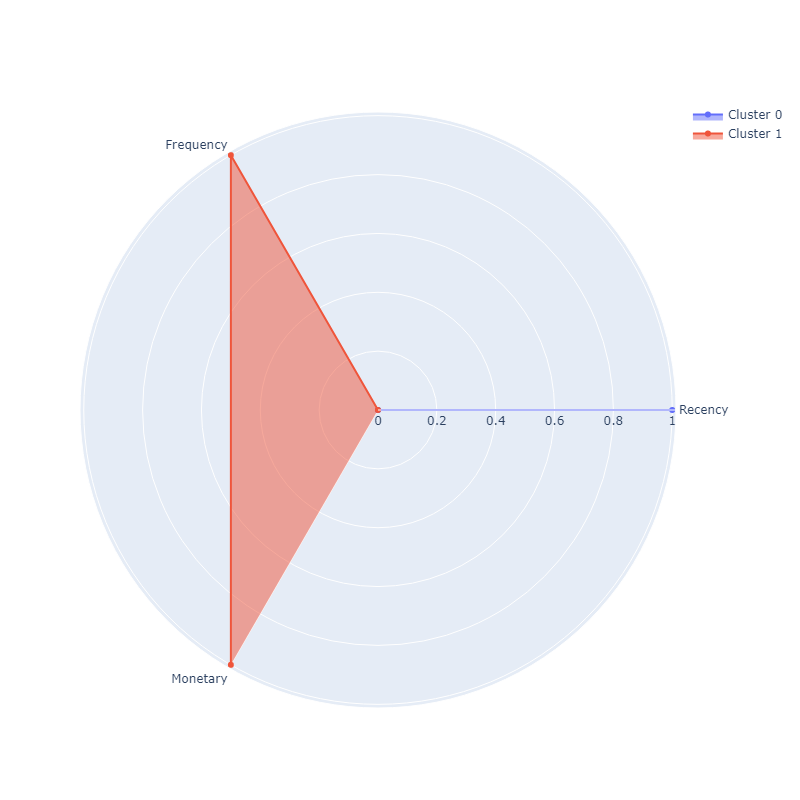

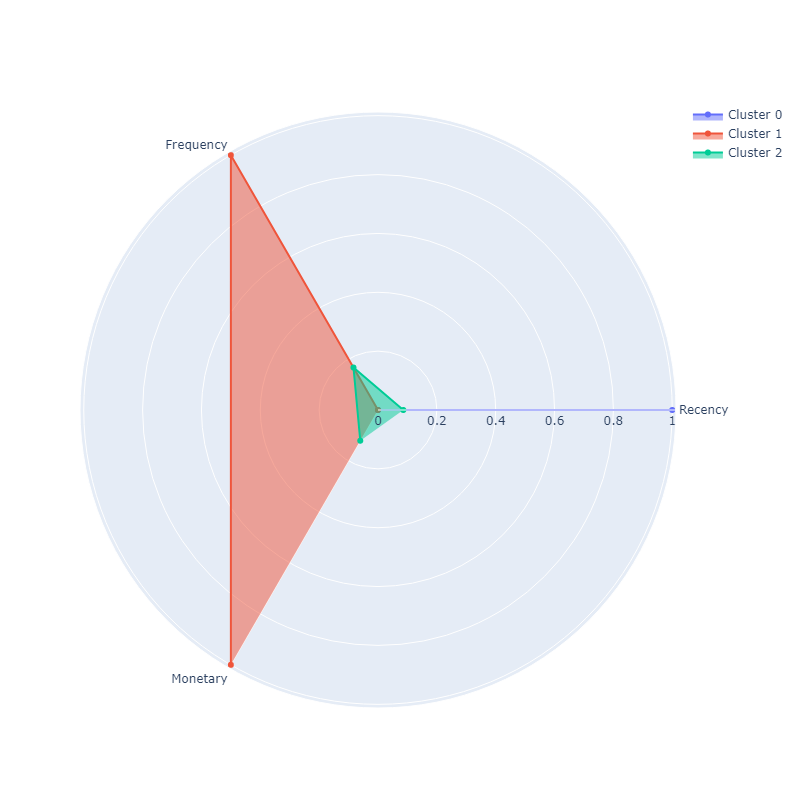

In [48]:
plot_cluster_profile(data = cluster_pca_grouped, n_clusters = 3)

**Выводы:**

* Кластер $0$ соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

* Кластер $1$ соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

* Кластер $2$ соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

## <center> **`5.` RFM-сегментация клиентов. Часть II**

С помощью *RFM*-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать бóльшим их количеством.

Ранее мы производили кластеризацию в пространстве главных компонент (*PCA*). А сейчас будем использовать нелинейную трансформацию: алгоритм снижения размерности *t-SNE*.

#### $5.1$

Задействуем алгоритм *t-SNE* и трансформируем *RFM*-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Для удобства обернём шаги по предобработке данных в *pipeline*. Создадим *pipeline*, который будет содержать следующие шаги:

* стандартизация с помощью *StandardScaler* с параметрами по умолчанию;
* алгоритм *t-SNE* с двумя компонентами, параметрами `perplexity=50` и `random_state=100`.

Обучим наш *pipeline* на *RFM*-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию.

In [49]:
# Инициализируем StandardScaler
STD_scaler = preprocessing.StandardScaler()


# Cоздаём объект класса TSNE
tsne = manifold.TSNE(
    n_components = 2,
    perplexity = 50,
    random_state = 100
)


# Задаём объект класса pipeline
pipeline_tsne = pipeline.Pipeline([
    ('scaler', STD_scaler),
    ('TSNE', tsne)
])

# Обучаем pipeline и применяем трансформацию к очищенной таблице
RFM_processed_tsne_data = pipeline_tsne.fit_transform(RFM_cleaned_data)


# Создаём DataFrame из полученной таблицы
RFM_processed_tsne_data = pd.DataFrame(
    data = RFM_processed_tsne_data,
    columns = ['axis-1', 'axis-2'],
    index = RFM_cleaned_data.index
)

In [50]:
# Выведем значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE
print('Значение дивергенции Кульбака — Лейблера: {:.2f}'.format(pipeline_tsne['TSNE'].kl_divergence_))

Значение дивергенции Кульбака — Лейблера: 0.54


Визуализируем пространство после декомпозиции с помощью *t-SNE*:

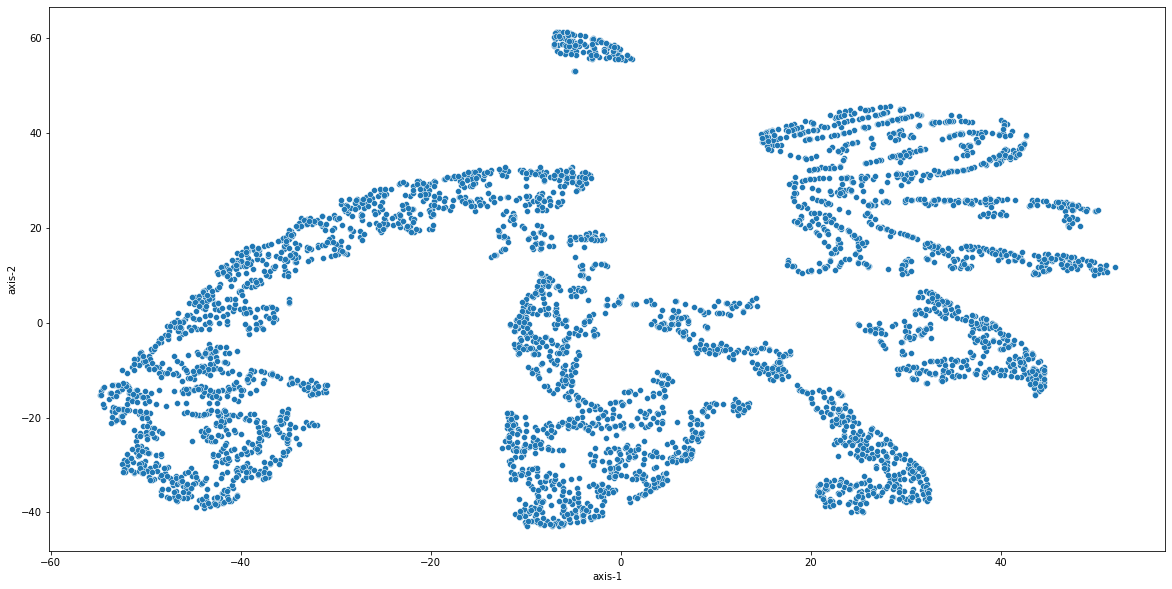

In [51]:
# Задаём параметры графика и строим его
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(
    data = RFM_processed_tsne_data,
    x = 'axis-1',
    y = 'axis-2'
);

**Вывод:**

Алгоритм *t-SNE* сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.

#### $5.2$

Воспользуемся методом *k-means*.

Подберём оптимальное количество кластеров для метода *k-means* с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. В качестве значения параметра `random_state` возьмём число 42. Остальные параметры оставим по умолчанию.

In [52]:
# Проходимся циклом по всем нужным нам значениям количества кластеров
for silhouette in range(3, 9):
    
    # Создаём объект класса KMeans
    KM_model = cluster.KMeans(
        n_clusters = silhouette,
        random_state = 42
    )
    
    # Oбучаем модель k-means с текущим количеством кластеров
    KM_model.fit(RFM_processed_tsne_data)
    
    # Предсказываем метки
    KM_predict = KM_model.labels_
    
    # Выводим результат для коэффициента силуэта
    print('Результат коэффициента силуэта {}: {:.4f}'.format(silhouette, metrics.silhouette_score(RFM_processed_tsne_data, KM_predict)))

Результат коэффициента силуэта 3: 0.4342
Результат коэффициента силуэта 4: 0.4793
Результат коэффициента силуэта 5: 0.4780
Результат коэффициента силуэта 6: 0.4792
Результат коэффициента силуэта 7: 0.4845
Результат коэффициента силуэта 8: 0.4820


#### $5.3$

Теперь попробуем воспользоваться методом *EM*-алгоритом.

Подберём оптимальное количество кластеров для метода *EM*-алгоритма (*GaussianMixture*) с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. В качестве значения параметра `random_state` возьмём число 42. Остальные параметры оставим по умолчанию.

In [53]:
# Проходимся циклом по всем нужным нам значениям количества кластеров
for silhouette in range(3, 9):
    
    # Создаём объект класса GaussianMixture
    GM_model = mixture.GaussianMixture(
        n_components = silhouette,
        random_state = 42
    )
    
    # Обучаем модель и предсказываем метки
    GM_predict = GM_model.fit_predict(RFM_processed_tsne_data)
    
    # Выводим результат для коэффициента силуэта
    print('Результат коэффициента силуэта {}: {:.4f}'.format(silhouette, metrics.silhouette_score(RFM_processed_tsne_data, GM_predict)))

Результат коэффициента силуэта 3: 0.4271
Результат коэффициента силуэта 4: 0.4688
Результат коэффициента силуэта 5: 0.4123
Результат коэффициента силуэта 6: 0.4572
Результат коэффициента силуэта 7: 0.4119
Результат коэффициента силуэта 8: 0.4292


#### $5.4$

Воспользуемся алгоритмом алгомеративной кластеризации (*AgglomerativeClustering*).

Подберём оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. Все параметры, за исключением числа кластеров, оставим по умолчанию.

In [54]:
# Проходимся циклом по всем нужным нам значениям количества кластеров
for silhouette in range(2, 9):
    
    # Создаём объект класса AgglomerativeClustering
    AC_model = cluster.AgglomerativeClustering(
        n_clusters = silhouette
    )
    
    # Обучаем модель и предсказываем метки
    AC_predict = AC_model.fit_predict(RFM_processed_tsne_data)
    
    # Выводим результат для коэффициента силуэта
    print('Результат коэффициента силуэта {}: {:.4f}'.format(silhouette, metrics.silhouette_score(RFM_processed_tsne_data, AC_predict)))

Результат коэффициента силуэта 2: 0.3797
Результат коэффициента силуэта 3: 0.4231
Результат коэффициента силуэта 4: 0.4566
Результат коэффициента силуэта 5: 0.4704
Результат коэффициента силуэта 6: 0.4692
Результат коэффициента силуэта 7: 0.4586
Результат коэффициента силуэта 8: 0.4790


#### **Вывод:**

Наилучшие значения параметров показала модель *K-means*.

#### $5.5$

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.

In [55]:
# Создаём объект класса KMeans
KM_model = cluster.KMeans(
    n_clusters = 7,
    random_state = 42
)

# Обучаем модель
KM_model.fit(RFM_processed_tsne_data)


# Выведем группы, а также количества входящих в них клиентов
RFM_processed_tsne_data.loc[:, 'label'] = KM_model.labels_
print(f'Группы, а также количества входящих в них клиентов: \n\n{RFM_processed_tsne_data.label.value_counts()}')

Группы, а также количества входящих в них клиентов: 

1    914
4    683
0    656
2    543
5    446
6    405
3    397
Name: label, dtype: int64


Визуализируем результаты кластеризации:

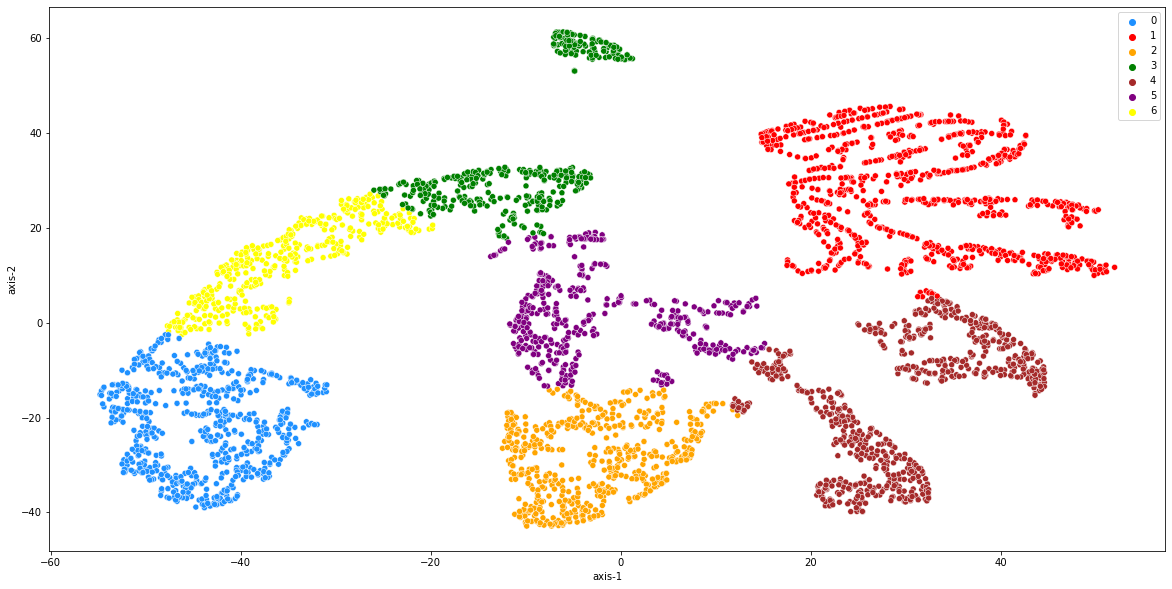

In [56]:
# Задаём параметры графика и строим его
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(
    data = RFM_processed_tsne_data,
    x = 'axis-1',
    y = 'axis-2',
    palette = ['dodgerblue', 'red', 'orange', 'green', 'brown', 'purple', 'yellow'],
    hue = KM_model.labels_
);

У нас есть семь сегментов клиентов. Составим профиль для этих сегментов.

#### $5.6$

Для составления профиля кластеров вернёмся от декомпозированных данных к *RFM*-таблице (очищенной от выбросов).

Сгруппируем *RFM*-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.

In [57]:
# Создаём столбец содержащий кластеры
labels = pd.Series(
    data = KM_model.labels_.astype('str'),
    index = RFM_processed_tsne_data.index
)


# Производим группировку
cluster_tsne_grouped = RFM_cleaned_data.groupby(labels).mean().round(0)

#### $5.7$

Визуализируем профили кластеров в виде полярной диаграммы на основе средних *RFM*-характеристик, вычисленных для каждого кластера. 

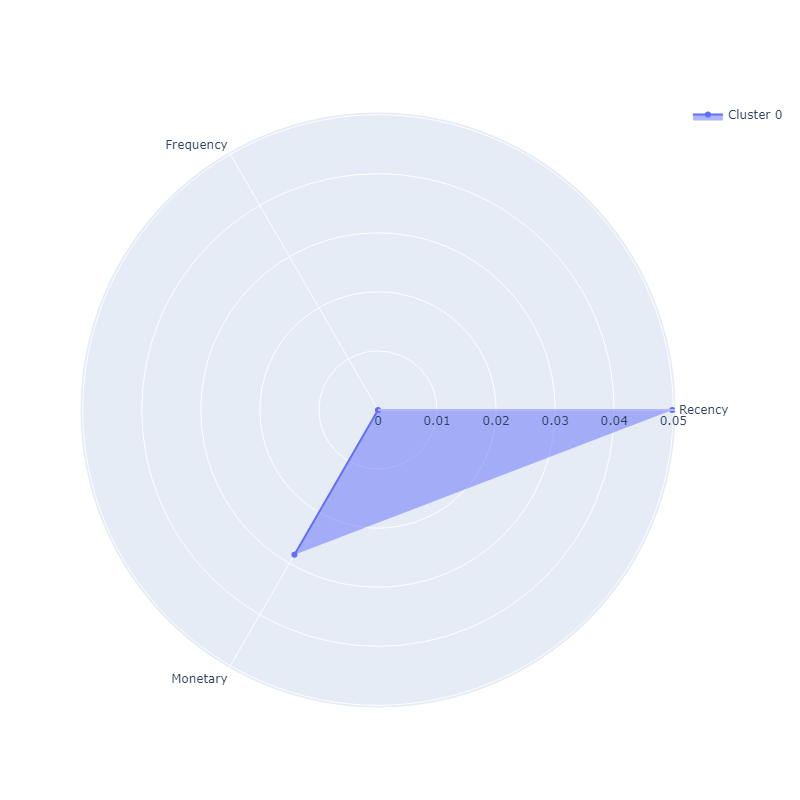

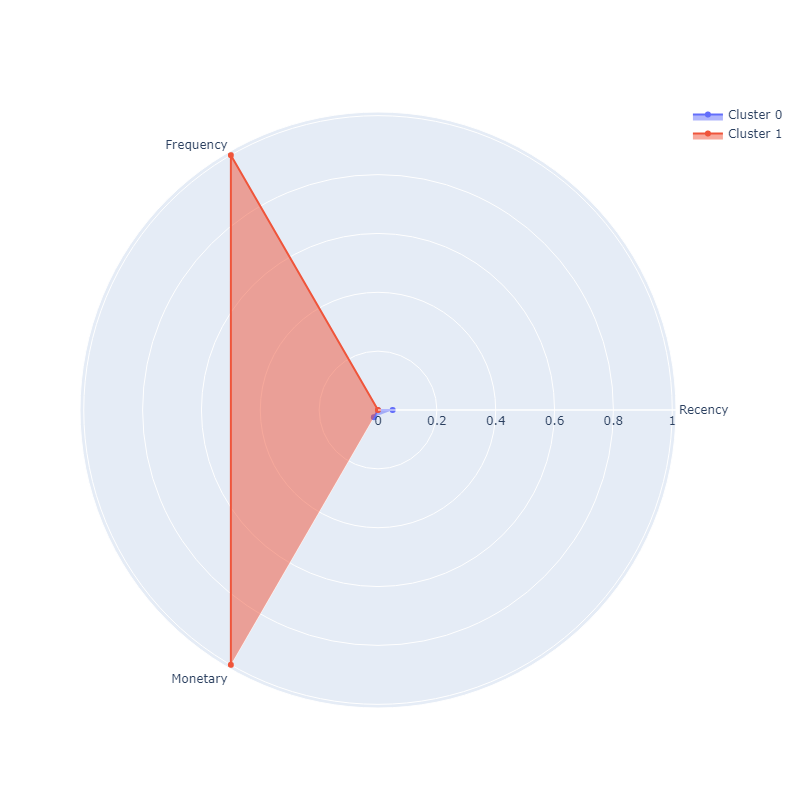

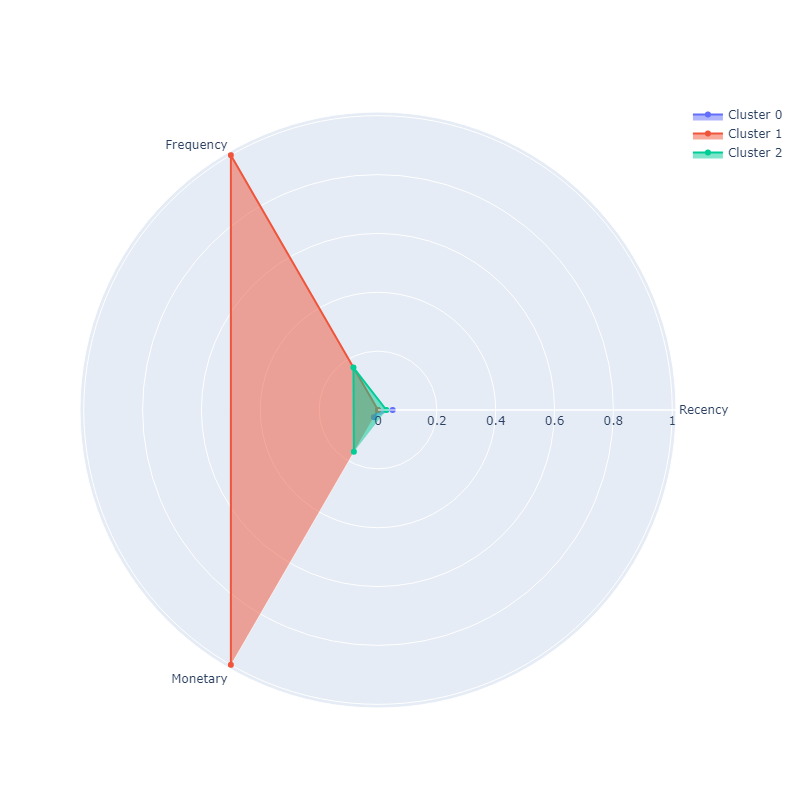

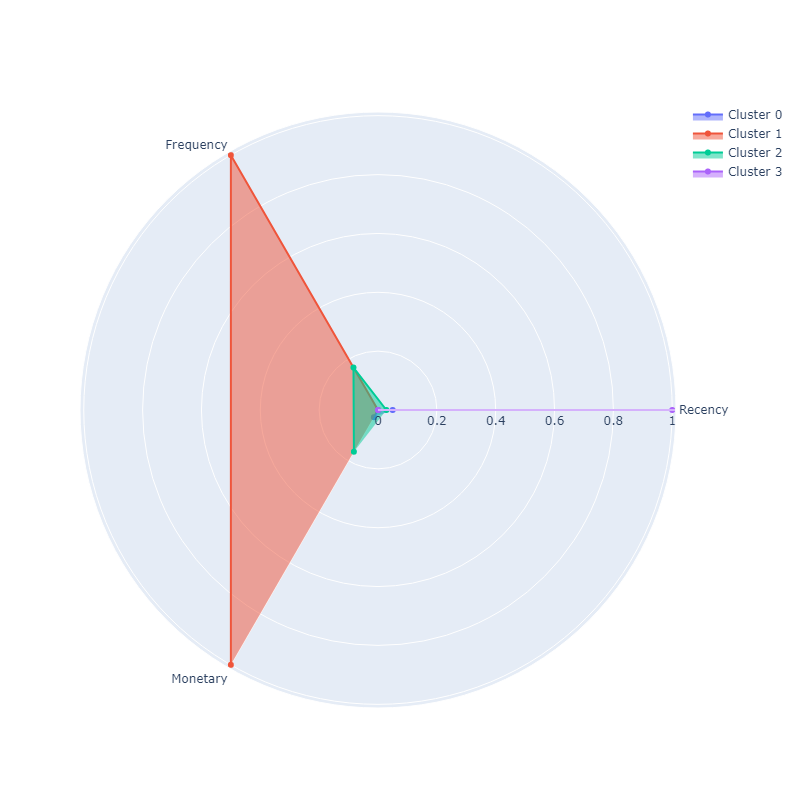

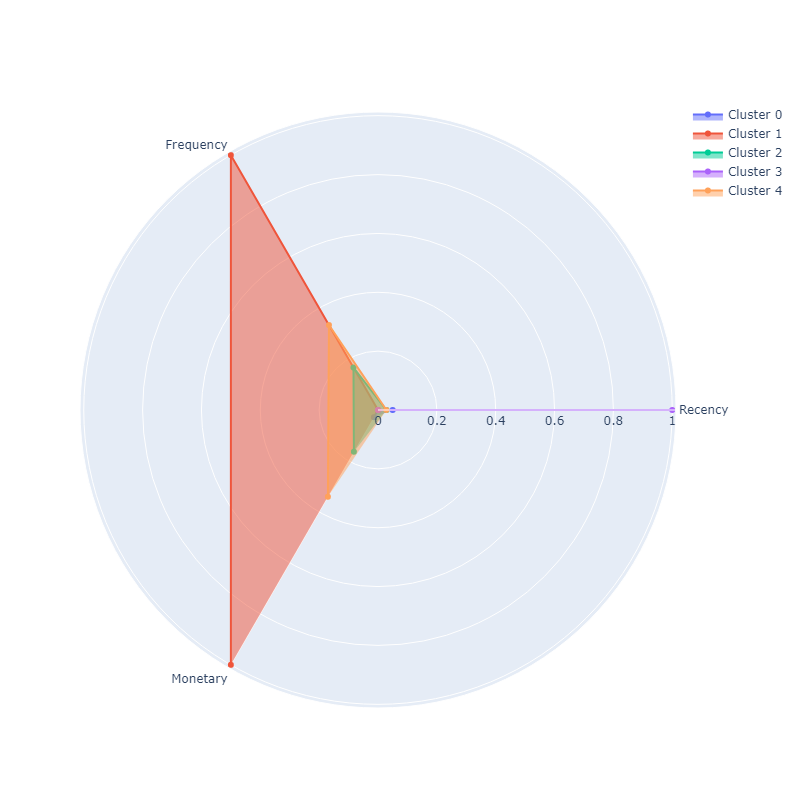

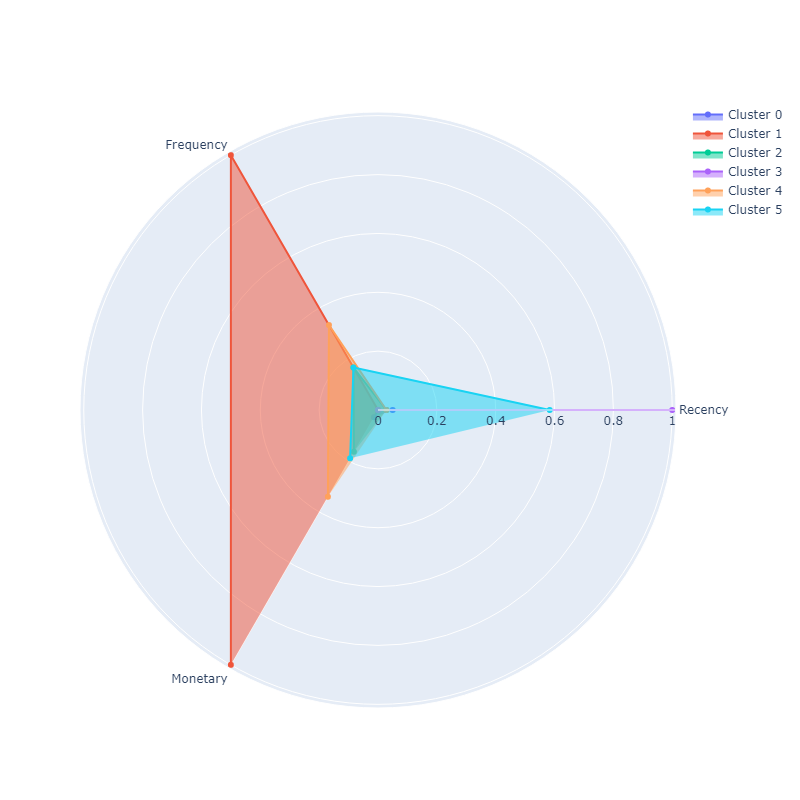

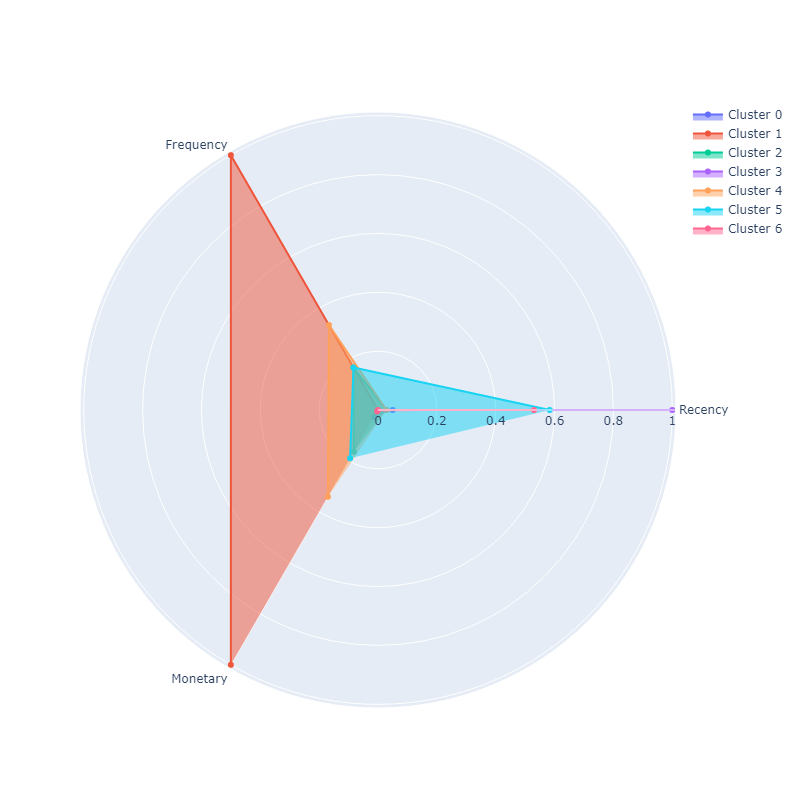

In [62]:
# Запускаем функцию
plot_cluster_profile(data = cluster_tsne_grouped, n_clusters = 7)

**Вывод:**

* Кластер $1$ соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

* Кластер $4$ соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.

* Кластер $2$ соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».

* Кластер $5$ соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.

* Кластер $0$ соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму.

* Кластер $6$ соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более пяти месяцев назад и больше не возвращались.

* Кластер $3$ соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## <center> **`6.` RFM-сегментация клиентов. Часть III**

Мы построили модель кластеризации для части клиентов. В этой части мы сделаем предсказание сегмента для клиентов, которые не попали в обучающую выборку.

Сведём задачу кластеризации к задаче классификации. Обучим модель, которая на основе *RFM*-характеристик будет предсказывать клиентский сегмент.

In [63]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = RFM_cleaned_data  # очищенная RFM-таблица
y = labels            # метки кластеров, предсказанные ранее

#### $6.1$

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра `random_state` возьмём число 42.

In [64]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 42)

In [68]:
# Выведем количества клиентов в тренировочной и тестовой выборках
print(f'Количество уникальных клиентов в тренировочной выборке: {X_train.index.nunique()}')
print(f'Количество уникальных клиентов в тестовой выборке: {X_test.index.nunique()}')

Количество уникальных клиентов в тренировочной выборке: 3235
Количество уникальных клиентов в тестовой выборке: 809


Далее построим несколько моделей и выберем из них лучшую.

Воспользуемся ансамблевыми алгоритмами.

#### $6.2$

Начнём со случайного леса. С помощью *GridSearchCV* организуем перебор параметров случайного леса (*RandomForestClassifier*) на заданной сетке параметров:

In [69]:
# Задаём сетку гиперпараметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}



# Инициализируем поиск на сетке и обучаем его
GS_model = model_selection.GridSearchCV(
    
    estimator = ensemble.RandomForestClassifier(random_state = 42),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1
)

# Обучаем модель и выводим наилучшие значения гиперпараметров
GS_model.fit(X_train, y_train)
print('Наилучшие значения гиперпараметров: {}'.format(GS_model.best_params_))

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}


С помощью наилучшей модели сделаем предсказание для обучающей и тестовой выборок. Рассчитаем значение метрики `accuracy` на каждой из выборок. Ответы **округлим до трёх знаков после точки-разделителя**.

In [70]:
# Определяем наилучшую модель
best_model = GS_model.best_estimator_

# Делаем предсказание на обеих выборках
y_train_gs_pred = best_model.predict(X_train)
y_test_gs_pred = best_model.predict(X_test)

# Считаем метрику accuracy на обучающей и тестовой выборках
print('Метрика accuracy на обучающем наборе: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_gs_pred)))
print('Метрика accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_gs_pred)))

Метрика accuracy на обучающем наборе: 1.000
Метрика accuracy на тестовом наборе: 0.985


Значение метрики `accuracy` очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

#### $6.3$

С помощью *GridSearchCV* организуем перебор параметров градиентного бустинга (*GradientBoostingClassifier*) на заданной сетке параметров:

In [71]:
# Задаём сетку гиперпараметров
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}



# Инициализируем поиск на сетке и обучаем его
GS_model = model_selection.GridSearchCV(
    
    estimator = ensemble.GradientBoostingClassifier(random_state = 42),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1
)

# Обучаем модель и выводим наилучшие значения гиперпараметров
GS_model.fit(X_train, y_train)
print('Наилучшие значения гиперпараметров: {}'.format(GS_model.best_params_))

Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


С помощью наилучшей модели сделаем предсказание для обучающей и тестовой выборок. Рассчитаем значение метрики `accuracy` на каждой из выборок. Ответы **округлим до трёх знаков после точки-разделителя**.

In [72]:
# Определяем наилучшую модель
best_model = GS_model.best_estimator_

# Делаем предсказание на обеих выборках
y_train_gs_pred = best_model.predict(X_train)
y_test_gs_pred = best_model.predict(X_test)

# Считаем метрику accuracy на обучающей и тестовой выборках
print('Метрика accuracy на обучающем наборе: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_gs_pred)))
print('Метрика accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_gs_pred)))

Метрика accuracy на обучающем наборе: 1.000
Метрика accuracy на тестовом наборе: 0.983


#### **Заключение:**

Мы справились с проблемой непараметричности *t-SNE* и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе *RFM*-характерик клиента автоматически определяет его сегмент.